In [1]:
#Import basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Data preprocessing libraries
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

#Model training and Validation
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [3]:
#Importing the data by converting it into dataframe

df=pd.read_csv('worldometer_snapshots_April18_to_May18.csv',parse_dates=['Date'])
df

,Date,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases
0,2020-04-18,USA,330774664,3722145.0,738792.0,39014.0,68269.0,13551.0,631509.0
1,2020-04-18,Russia,145927292,1831892.0,36793.0,313.0,3057.0,8.0,33423.0
2,2020-04-18,Spain,46752703,930230.0,194416.0,20043.0,74797.0,7371.0,99576.0
3,2020-04-18,Brazil,212380932,62985.0,36722.0,2361.0,14026.0,6634.0,20335.0
4,2020-04-18,UK,67844241,460437.0,114217.0,15464.0,NaN,1559.0,98409.0
...,...,...,...,...,...,...,...,...,...
6598,2020-05-18,St. Barth,9874,NaN,6.0,NaN,6.0,NaN,0.0
6599,2020-05-18,Western Sahara,595462,NaN,6.0,NaN,6.0,NaN,0.0
6600,2020-05-18,Anguilla,14987,NaN,3.0,NaN,3.0,NaN,0.0
6601,2020-05-18,Lesotho,2140235,NaN,1.0,NaN,NaN,NaN,1.0


In [4]:
#importing data about age structure for every country
age_df=pd.read_csv('population_structure_by_age_per_country.csv')
age_df


,Country,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,USA,0.189,0.657,0.154
1,Russia,0.176,0.682,0.142
2,Spain,0.147,0.659,0.194
3,Brazil,0.217,0.697,0.086
4,UK,0.177,0.638,0.185
...,...,...,...,...
208,St. Barth,NaN,NaN,NaN
209,Western Sahara,NaN,NaN,NaN
210,Anguilla,NaN,NaN,NaN
211,Lesotho,0.354,0.601,0.045


## The Objective here is to estimate the true death rate of COVID19 and see its relationship with the age.


### Clean world COVID dataset

In [5]:
#checking shape of the dataset

df.shape

(6603, 9)

In [6]:
#Checking columns
df.columns

Index(['Date', 'Country', 'Population', 'Total Tests', 'Total Cases',
       'Total Deaths', 'Total Recovered', 'Serious or Critical',
       'Active Cases'],
      dtype='object')

In [7]:
#checking datatypes
df.dtypes

Date                   datetime64[ns]
Country                        object
Population                      int64
Total Tests                   float64
Total Cases                   float64
Total Deaths                  float64
Total Recovered               float64
Serious or Critical           float64
Active Cases                  float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 6603 non-null   datetime64[ns]
 1   Country              6603 non-null   object        
 2   Population           6603 non-null   int64         
 3   Total Tests          5505 non-null   float64       
 4   Total Cases          6554 non-null   float64       
 5   Total Deaths         5367 non-null   float64       
 6   Total Recovered      6318 non-null   float64       
 7   Serious or Critical  4117 non-null   float64       
 8   Active Cases         6544 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 464.4+ KB


Observation:
    1.There are 6603 rows and 9 columns in the data set.
    2.only country is object type,others are of float and int datatypes.
    3.missing values present in many features.

In [9]:
#Checking for null values

df.isnull().sum()

Date                      0
Country                   0
Population                0
Total Tests            1098
Total Cases              49
Total Deaths           1236
Total Recovered         285
Serious or Critical    2486
Active Cases             59
dtype: int64

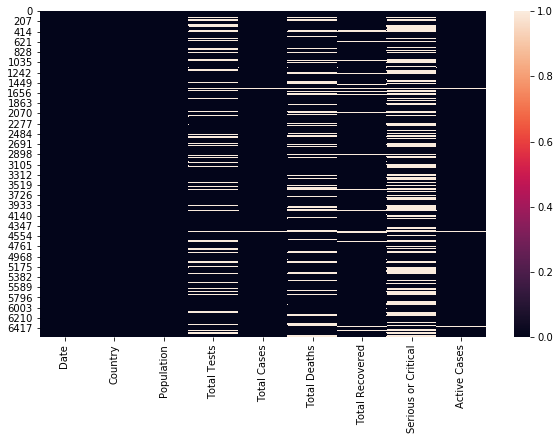

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull())

In [11]:
for i in df.columns:
    print(df[df[i].isna()])

Empty DataFrame
Columns: [Date, Country, Population, Total Tests, Total Cases, Total Deaths, Total Recovered, Serious or Critical, Active Cases]
Index: []
Empty DataFrame
Columns: [Date, Country, Population, Total Tests, Total Cases, Total Deaths, Total Recovered, Serious or Critical, Active Cases]
Index: []
Empty DataFrame
Columns: [Date, Country, Population, Total Tests, Total Cases, Total Deaths, Total Recovered, Serious or Critical, Active Cases]
Index: []
           Date                Country  Population  Total Tests  Total Cases  \
12   2020-04-18                  China  1439323776          NaN      82719.0   
39   2020-04-18                 Kuwait     4262847          NaN       1751.0   
52   2020-04-18            Afghanistan    38817349          NaN        933.0   
61   2020-04-18                   Oman     5089968          NaN       1180.0   
67   2020-04-18               Cameroon    26461313          NaN       1017.0   
...         ...                    ...         ...     

In [12]:
#drop null values

print('Initial Shape:',df.shape)
df.dropna(axis=0,how='any',inplace=True)
print('Final Shape:',df.shape)

Initial Shape: (6603, 9)
Final Shape: (3514, 9)


In [13]:
df.isnull().sum()

Date                   0
Country                0
Population             0
Total Tests            0
Total Cases            0
Total Deaths           0
Total Recovered        0
Serious or Critical    0
Active Cases           0
dtype: int64

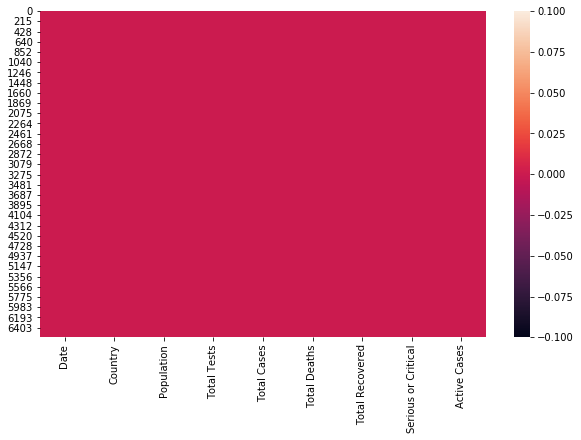

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull())

## Statistical Summary

In [15]:
#checking statistics of numerical data
df.describe()

,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases
count,3.514000e+03,3.514000e+03,3.514000e+03,3514.000000,3514.000000,3514.000000,3.514000e+03
mean,3.028296e+07,3.067297e+05,2.808735e+04,1814.474104,9585.632043,431.913773,1.670741e+04
std,5.264014e+07,9.204304e+05,1.182160e+05,7756.667550,30061.057147,1784.497637,8.765856e+04
min,4.992000e+03,3.600000e+01,1.100000e+01,0.000000,2.000000,1.000000,1.000000e+00
25%,2.878155e+06,1.438900e+04,7.252500e+02,11.000000,221.000000,4.000000,3.122500e+02
50%,9.875965e+06,6.651500e+04,2.741000e+03,64.000000,906.000000,18.000000,1.324000e+03
75%,3.474733e+07,2.147610e+05,1.226400e+04,325.500000,3662.250000,111.000000,7.201250e+03
max,3.307747e+08,1.230074e+07,1.550294e+06,91981.000000,356383.000000,18671.000000,1.101930e+06


Observation: Mean is greater than median so data is right skewed.
    Dataset has lot of outliers.

In [16]:
#checking correlation

df.corr()

,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases
Population,1.000000,0.571506,0.610035,0.542677,0.512286,0.663715,0.599638
Total Tests,0.571506,1.000000,0.901143,0.822011,0.821648,0.745462,0.861574
Total Cases,0.610035,0.901143,1.000000,0.945894,0.834441,0.893691,0.979611
Total Deaths,0.542677,0.822011,0.945894,1.000000,0.849554,0.852833,0.896553
Total Recovered,0.512286,0.821648,0.834441,0.849554,1.000000,0.740360,0.707767
Serious or Critical,0.663715,0.745462,0.893691,0.852833,0.740360,1.000000,0.876725
Active Cases,0.599638,0.861574,0.979611,0.896553,0.707767,0.876725,1.000000


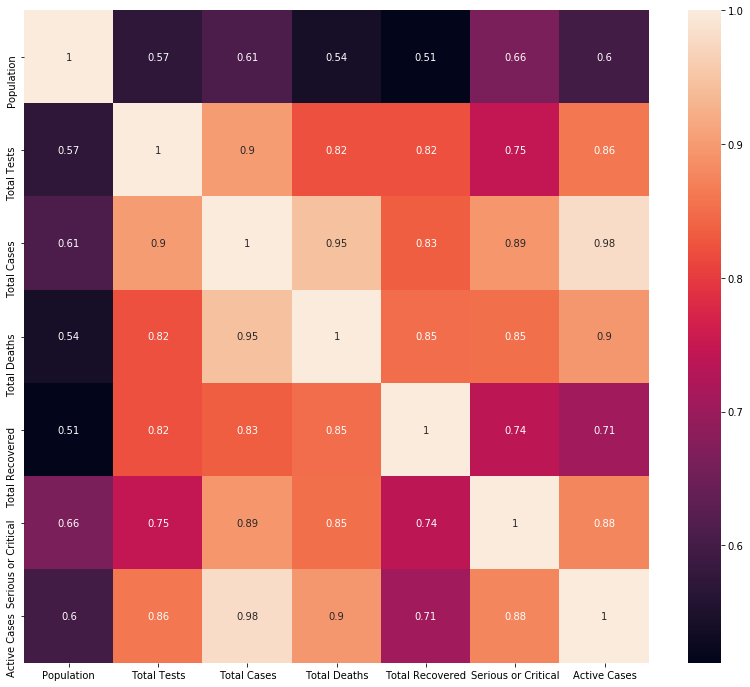

In [17]:
#checking correlation using heatmap

plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),annot=True)

Observation:
    1.Population is negatively correlated to Total Recovered.
    2.Most of the features are positively correlated to each other.

In [18]:
#Separating categorical columns and numerical columns

cat_df,num_df=[],[]
for i in df:
    if df[i].dtypes=='object':
        cat_df.append(i)
    elif (df[i].dtypes=='int') | (df[i].dtypes=='float') | (df[i].dtypes=='int64'):
        num_df.append(i)

    else:print('Others>',i) 
print('Total number of features:',df.shape[1])
print('Number of categorical features:',len(cat_df))
print('Number of numerical features:',len(num_df))

Others> Date
Total number of features: 9
Number of categorical features: 1
Number of numerical features: 7


Skewness of Population = 3.11
Skewness of Total Tests = 7.16
Skewness of Total Cases = 9.14
Skewness of Total Deaths = 7.24
Skewness of Total Recovered = 5.55
Skewness of Serious or Critical = 6.76
Skewness of Active Cases = 9.99


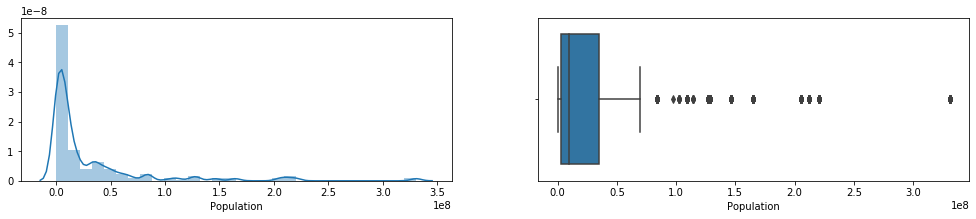

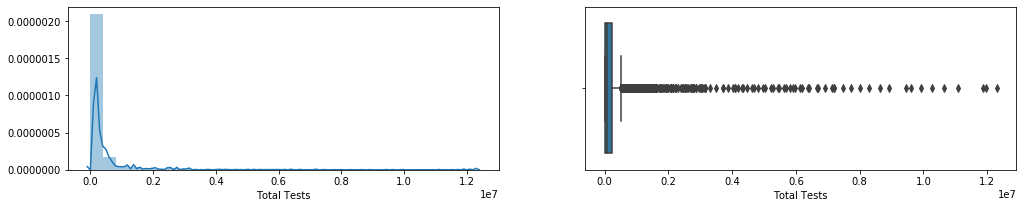

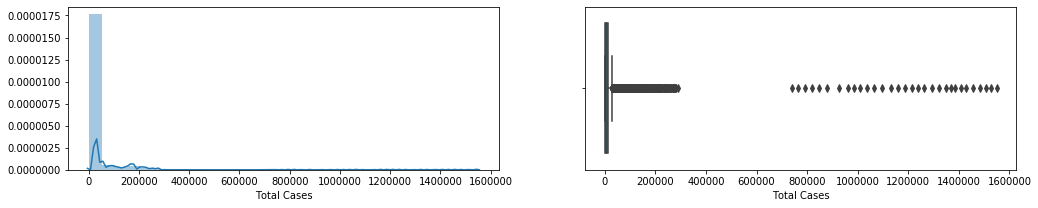

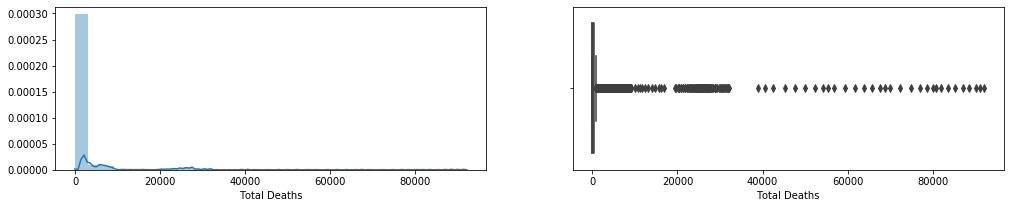

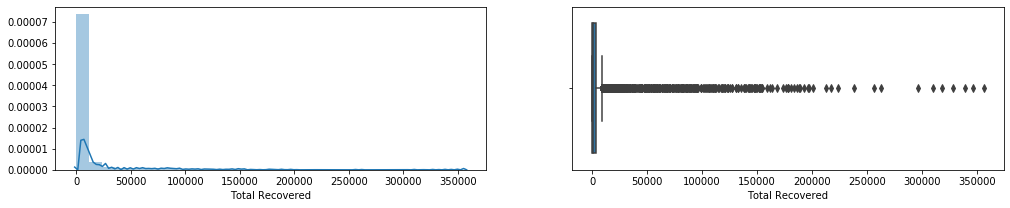

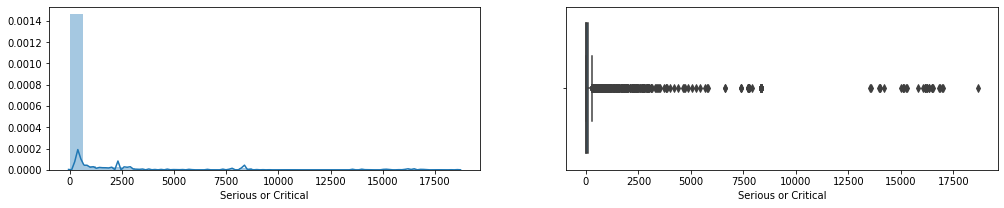

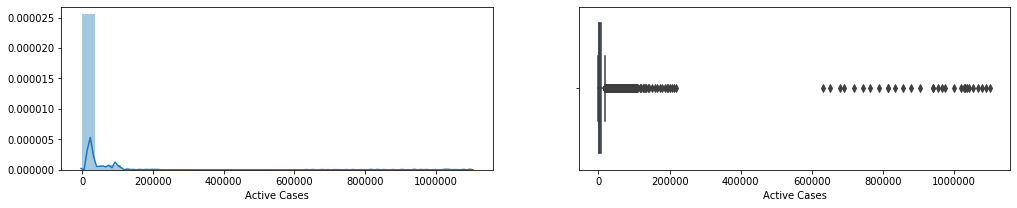

In [20]:
#univariate analysis of numerical features
for i in num_df:
    f=plt.figure(figsize=(17,3))
    f.add_subplot(1,2,1)
    sns.distplot(df[i],bins=30)
    f.add_subplot(1,2,2)
    sns.boxplot(df[i])
    print('Skewness of %s = %0.2f' %(i,df[i].skew()))

In [21]:
df['Date'].min()

Timestamp('2020-04-18 00:00:00')

In [22]:
df['Date'].max()

Timestamp('2020-05-18 00:00:00')

Finding: One month data is been collected from 18-4-2020 to 18-5-2020. 

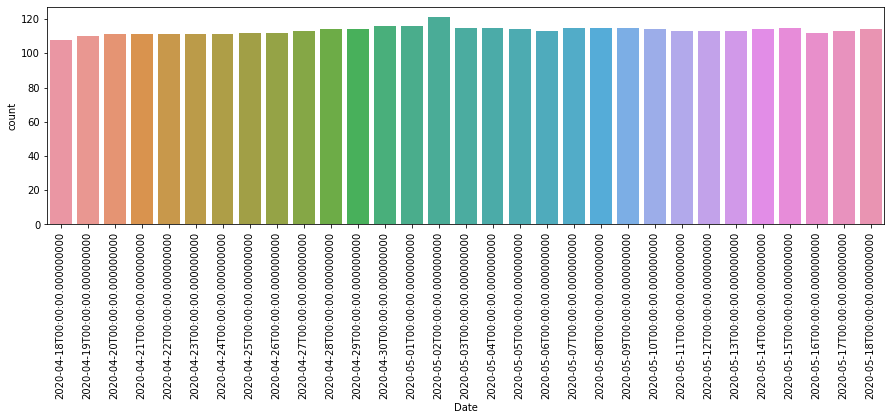

In [23]:
plt.figure(figsize=(15,4))
plt.xticks(rotation='vertical')
sns.countplot(x='Date',data=df)

In [24]:
df1=df.copy()

In [25]:
df1.shape

(3514, 9)

In [26]:
#finding out the last date of totl cases to estimate true death rate

final_df=df1[df1['Date']==df1['Date'].max()]

In [27]:
final_df.head()

,Date,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases
6390,2020-05-18,USA,330774664,12300744.0,1550294.0,91981.0,356383.0,16868.0,1101930.0
6391,2020-05-18,Russia,145927292,7147014.0,290678.0,2722.0,70209.0,2300.0,217747.0
6392,2020-05-18,Spain,46752703,3037840.0,278188.0,27709.0,196958.0,1152.0,53521.0
6393,2020-05-18,Brazil,212380932,735224.0,255368.0,16853.0,100459.0,8318.0,138056.0
6395,2020-05-18,Italy,60471924,3041366.0,225886.0,32007.0,127326.0,749.0,66553.0


In [28]:
#checking the country where maximum number of confirmed cases are present

most_affected_country=df.groupby(by='Country')['Total Deaths'].sum().sort_values(ascending=False).reset_index()
most_affected_country

,Country,Total Deaths
0,USA,2102393.0
1,Italy,881699.0
2,Spain,767305.0
3,France,761760.0
4,Brazil,248971.0
...,...,...
123,Cambodia,0.0
124,Grenada,0.0
125,French Polynesia,0.0
126,New Caledonia,0.0


In [29]:
#Checking the country where maximum recovered

most_recovered_country=df.groupby(by='Country')['Total Recovered'].sum().sort_values(ascending=False).reset_index()
most_recovered_country

,Country,Total Recovered
0,USA,6004896.0
1,Spain,4401203.0
2,Germany,3934213.0
3,Italy,2621286.0
4,Iran,2401164.0
...,...,...
123,Belize,110.0
124,French Polynesia,51.0
125,Nepal,36.0
126,New Caledonia,17.0


In [30]:
#Checking maximum confirmed cases in each country

most_confirmed_country=df.groupby(by='Country')['Active Cases'].sum().sort_values(ascending=False).reset_index()
most_confirmed_country

,Country,Active Cases
0,USA,28115408.0
1,Russia,3802264.0
2,Italy,2915063.0
3,France,2912277.0
4,Spain,2380836.0
...,...,...
123,Vietnam,52.0
124,Grenada,8.0
125,French Polynesia,7.0
126,Cambodia,2.0


### True Death Rate(TDR) is calculated by dividing Total Deaths and Active cases

In [31]:
final_df['TDR']=final_df['Total Deaths']/final_df['Active Cases']
final_df.shape

(114, 10)

In [32]:
final_df

,Date,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,TDR
6390,2020-05-18,USA,330774664,12300744.0,1550294.0,91981.0,356383.0,16868.0,1101930.0,0.083473
6391,2020-05-18,Russia,145927292,7147014.0,290678.0,2722.0,70209.0,2300.0,217747.0,0.012501
6392,2020-05-18,Spain,46752703,3037840.0,278188.0,27709.0,196958.0,1152.0,53521.0,0.517722
6393,2020-05-18,Brazil,212380932,735224.0,255368.0,16853.0,100459.0,8318.0,138056.0,0.122074
6395,2020-05-18,Italy,60471924,3041366.0,225886.0,32007.0,127326.0,749.0,66553.0,0.480925
...,...,...,...,...,...,...,...,...,...,...
6554,2020-05-18,Bahamas,392795,1826.0,96.0,11.0,43.0,1.0,42.0,0.261905
6556,2020-05-18,Barbados,287335,4004.0,88.0,7.0,68.0,4.0,13.0,0.538462
6559,2020-05-18,Sint Maarten,42817,414.0,77.0,15.0,54.0,7.0,8.0,1.875000
6560,2020-05-18,Malawi,19066433,1803.0,70.0,3.0,27.0,1.0,40.0,0.075000


## Clean age_df Dataset

In [33]:
##Checking the shape 
age_df.shape

(213, 4)

In [34]:
#Checking columns
age_df.columns

Index(['Country', 'Fraction age 0-14 years', 'Fraction age 15-64 years',
       'Fraction age 65+ years'],
      dtype='object')

In [35]:
#Checking datatypes
age_df.dtypes

Country                      object
Fraction age 0-14 years     float64
Fraction age 15-64 years    float64
Fraction age 65+ years      float64
dtype: object

In [36]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   213 non-null    object 
 1   Fraction age 0-14 years   176 non-null    float64
 2   Fraction age 15-64 years  176 non-null    float64
 3   Fraction age 65+ years    176 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.8+ KB


Observation:
    There are no missing values present in feature country,remaining features missing
    values are present.

In [37]:
#Checking null values
age_df.isnull().sum()

Country                      0
Fraction age 0-14 years     37
Fraction age 15-64 years    37
Fraction age 65+ years      37
dtype: int64

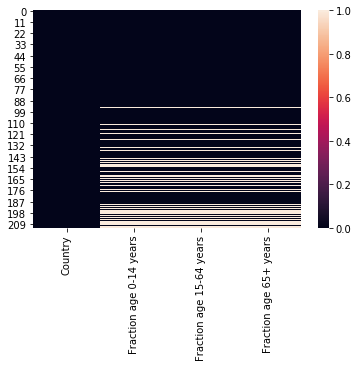

In [38]:
sns.heatmap(age_df.isnull())
plt.show()


In [39]:
#Find null values

for i in age_df.columns:
    print(age_df[age_df[i].isna()])

Empty DataFrame
Columns: [Country, Fraction age 0-14 years, Fraction age 15-64 years, Fraction age 65+ years]
Index: []
                    Country  Fraction age 0-14 years  \
95                  Mayotte                      NaN   
112                 Andorra                      NaN   
117              San Marino                      NaN   
121         Channel Islands                      NaN   
127                 Réunion                      NaN   
134             Isle of Man                      NaN   
137              Cabo Verde                      NaN   
145   Sao Tome and Principe                      NaN   
147           French Guiana                      NaN   
149              Martinique                      NaN   
151          Faeroe Islands                      NaN   
152              Guadeloupe                      NaN   
153               Gibraltar                      NaN   
158                 Bermuda                      NaN   
162                   Aruba             

In [40]:
#drop null values
print('Initial shape:',age_df.shape)
age_df.dropna(axis=0,how='any',inplace=True)
print('Final shape:',age_df.shape)

Initial shape: (213, 4)
Final shape: (176, 4)


In [41]:
age_df.isnull().sum()

Country                     0
Fraction age 0-14 years     0
Fraction age 15-64 years    0
Fraction age 65+ years      0
dtype: int64

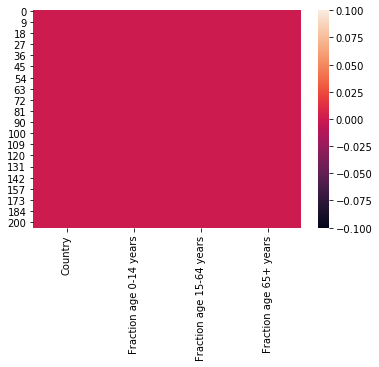

In [44]:
sns.heatmap(age_df.isnull())
plt.show()

In [45]:
#checking statistics of numeric values

age_df.describe()

,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
count,176.000000,176.000000,176.000000
mean,0.276098,0.636109,0.087731
std,0.106748,0.066543,0.062522
min,0.115000,0.472000,0.011000
25%,0.177000,0.596750,0.034000
50%,0.266500,0.649000,0.063500
75%,0.368250,0.675250,0.143250
max,0.502000,0.850000,0.270000


In [46]:
#Checking correlation
age_df.corr()

,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
Fraction age 0-14 years,1.000000,-0.839259,-0.815133
Fraction age 15-64 years,-0.839259,1.000000,0.369285
Fraction age 65+ years,-0.815133,0.369285,1.000000


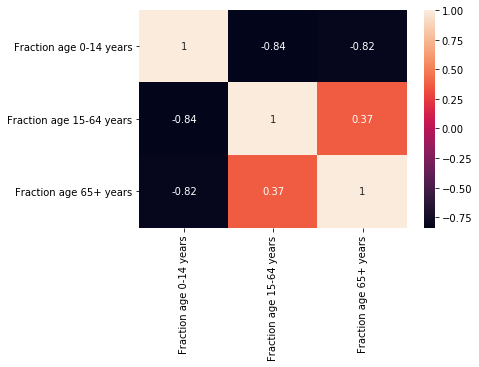

In [47]:
#checking correlation using heatmap
sns.heatmap(age_df.corr(),annot=True)

In [48]:
age_df

,Country,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,USA,0.189,0.657,0.154
1,Russia,0.176,0.682,0.142
2,Spain,0.147,0.659,0.194
3,Brazil,0.217,0.697,0.086
4,UK,0.177,0.638,0.185
...,...,...,...,...
200,Comoros,0.398,0.573,0.030
202,Suriname,0.264,0.666,0.069
204,Seychelles,0.222,0.692,0.086
206,Papua New Guinea,0.359,0.603,0.038


In [49]:
final_df

,Date,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,TDR
6390,2020-05-18,USA,330774664,12300744.0,1550294.0,91981.0,356383.0,16868.0,1101930.0,0.083473
6391,2020-05-18,Russia,145927292,7147014.0,290678.0,2722.0,70209.0,2300.0,217747.0,0.012501
6392,2020-05-18,Spain,46752703,3037840.0,278188.0,27709.0,196958.0,1152.0,53521.0,0.517722
6393,2020-05-18,Brazil,212380932,735224.0,255368.0,16853.0,100459.0,8318.0,138056.0,0.122074
6395,2020-05-18,Italy,60471924,3041366.0,225886.0,32007.0,127326.0,749.0,66553.0,0.480925
...,...,...,...,...,...,...,...,...,...,...
6554,2020-05-18,Bahamas,392795,1826.0,96.0,11.0,43.0,1.0,42.0,0.261905
6556,2020-05-18,Barbados,287335,4004.0,88.0,7.0,68.0,4.0,13.0,0.538462
6559,2020-05-18,Sint Maarten,42817,414.0,77.0,15.0,54.0,7.0,8.0,1.875000
6560,2020-05-18,Malawi,19066433,1803.0,70.0,3.0,27.0,1.0,40.0,0.075000


### To estimate true death rate of COVID19 and examining its relationship with age

In [50]:
#merge both datasets

df_examin=pd.merge(final_df,age_df,on='Country')

In [51]:
df_examin

,Date,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,TDR,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,2020-05-18,USA,330774664,12300744.0,1550294.0,91981.0,356383.0,16868.0,1101930.0,0.083473,0.189,0.657,0.154
1,2020-05-18,Russia,145927292,7147014.0,290678.0,2722.0,70209.0,2300.0,217747.0,0.012501,0.176,0.682,0.142
2,2020-05-18,Spain,46752703,3037840.0,278188.0,27709.0,196958.0,1152.0,53521.0,0.517722,0.147,0.659,0.194
3,2020-05-18,Brazil,212380932,735224.0,255368.0,16853.0,100459.0,8318.0,138056.0,0.122074,0.217,0.697,0.086
4,2020-05-18,Italy,60471924,3041366.0,225886.0,32007.0,127326.0,749.0,66553.0,0.480925,0.135,0.635,0.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2020-05-18,Guyana,786108,1164.0,124.0,10.0,44.0,3.0,70.0,0.142857,0.281,0.657,0.053
102,2020-05-18,Bahamas,392795,1826.0,96.0,11.0,43.0,1.0,42.0,0.261905,0.205,0.706,0.090
103,2020-05-18,Barbados,287335,4004.0,88.0,7.0,68.0,4.0,13.0,0.538462,0.191,0.660,0.150
104,2020-05-18,Malawi,19066433,1803.0,70.0,3.0,27.0,1.0,40.0,0.075000,0.440,0.530,0.030


In [52]:
df.shape

(3514, 9)

In [53]:
df['TDR']=df['Total Deaths']/df['Active Cases']
df.head()

,Date,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,TDR
0,2020-04-18,USA,330774664,3722145.0,738792.0,39014.0,68269.0,13551.0,631509.0,0.061779
1,2020-04-18,Russia,145927292,1831892.0,36793.0,313.0,3057.0,8.0,33423.0,0.009365
2,2020-04-18,Spain,46752703,930230.0,194416.0,20043.0,74797.0,7371.0,99576.0,0.201283
3,2020-04-18,Brazil,212380932,62985.0,36722.0,2361.0,14026.0,6634.0,20335.0,0.116105
5,2020-04-18,Italy,60471924,1305833.0,175925.0,23227.0,44927.0,2733.0,107771.0,0.215522


In [54]:
df_examin=pd.merge(df,age_df,on='Country')

In [55]:
df_examin.drop(columns=['Date'],axis=1,inplace=True)
df_examin.head(5)

,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,TDR,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,USA,330774664,3722145.0,738792.0,39014.0,68269.0,13551.0,631509.0,0.061779,0.189,0.657,0.154
1,USA,330774664,3861549.0,763832.0,40553.0,71003.0,13566.0,652276.0,0.062172,0.189,0.657,0.154
2,USA,330774664,4026360.0,792759.0,42514.0,72389.0,13951.0,677856.0,0.062718,0.189,0.657,0.154
3,USA,330774664,4187392.0,818744.0,45318.0,82923.0,14016.0,690503.0,0.065630,0.189,0.657,0.154
4,USA,330774664,4325342.0,848717.0,47659.0,84050.0,14016.0,717008.0,0.066469,0.189,0.657,0.154


In [56]:
print(df_examin.columns)
print(df_examin.shape)

Index(['Country', 'Population', 'Total Tests', 'Total Cases', 'Total Deaths',
       'Total Recovered', 'Serious or Critical', 'Active Cases', 'TDR',
       'Fraction age 0-14 years', 'Fraction age 15-64 years',
       'Fraction age 65+ years'],
      dtype='object')
(3242, 12)


## Machine Learning Algorithm

In [57]:
#Splitting data into input and output variables

x=df_examin.drop(columns=['TDR'],axis=1)
x.head()

,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,USA,330774664,3722145.0,738792.0,39014.0,68269.0,13551.0,631509.0,0.189,0.657,0.154
1,USA,330774664,3861549.0,763832.0,40553.0,71003.0,13566.0,652276.0,0.189,0.657,0.154
2,USA,330774664,4026360.0,792759.0,42514.0,72389.0,13951.0,677856.0,0.189,0.657,0.154
3,USA,330774664,4187392.0,818744.0,45318.0,82923.0,14016.0,690503.0,0.189,0.657,0.154
4,USA,330774664,4325342.0,848717.0,47659.0,84050.0,14016.0,717008.0,0.189,0.657,0.154


In [58]:
y=df_examin['TDR']
y.head()

0    0.061779
1    0.062172
2    0.062718
3    0.065630
4    0.066469
Name: TDR, dtype: float64

In [59]:
print(x.shape,'\t\t',y.shape)

(3242, 11) 		 (3242,)


In [60]:
#Transforming categorical data into numericl data

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
for column in x.columns:
    if x[column].dtype==np.number:
        continue
    x[column]=le.fit_transform(x[column])

In [61]:
x.head()

,Country,Population,Total Tests,Total Cases,Total Deaths,Total Recovered,Serious or Critical,Active Cases,Fraction age 0-14 years,Fraction age 15-64 years,Fraction age 65+ years
0,109,115,3722145.0,738792.0,39014.0,68269.0,13551.0,631509.0,0.189,0.657,0.154
1,109,115,3861549.0,763832.0,40553.0,71003.0,13566.0,652276.0,0.189,0.657,0.154
2,109,115,4026360.0,792759.0,42514.0,72389.0,13951.0,677856.0,0.189,0.657,0.154
3,109,115,4187392.0,818744.0,45318.0,82923.0,14016.0,690503.0,0.189,0.657,0.154
4,109,115,4325342.0,848717.0,47659.0,84050.0,14016.0,717008.0,0.189,0.657,0.154


In [62]:
#Scaling input data

from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
x=ss.fit_transform(x)

In [65]:
#Splitting the data into training and testing data

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.22,random_state=42
                                              )

In [66]:
print(x_train.shape,'\t\t',x_test.shape)
print(y_train.shape,'\t\t',y_test.shape)

(2528, 11) 		 (714, 11)
(2528,) 		 (714,)


In [69]:
#Importing all the model libraries
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV,cross_val_score



In [70]:
#Initialising the models with default parameters as the data set is very huge

LR=LinearRegression()
Ridge=Ridge()
Lasso=Lasso()
ElasticNet=ElasticNet()
KNR=KNeighborsRegressor()
SVR=SVR()
DTR=DecisionTreeRegressor()
RFR=RandomForestRegressor()
GBR=GradientBoostingRegressor()
ABR=AdaBoostRegressor()
ETR=ExtraTreesRegressor()
BR=BaggingRegressor()

In [71]:
models=[]
models.append(('LinearRegression',LR))
models.append(('Ridge',Ridge))
models.append(('Lasso',Lasso))
models.append(('ElasticNet',ElasticNet))
models.append(('KNeighborsRegressor',KNR))
models.append(('SVR',SVR))
models.append(('DecisionTreeRegressor',DTR))
models.append(('RandomForestRegressor',RFR))
models.append(('GradientBoostingRegressor',GBR))
models.append(('AdaBoostRegressor',ABR))
models.append(('ExtraTreesRegressor',ETR))
models.append(('BaggingRegressor',BR))

In [72]:
Model=[]
Score=[]
R2_Score=[]
CVS=[]
MAE=[]
MSE=[]
RMSE=[]

for name,model in models:
    print('**************************',name,'*********************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    
    #Score
    score=model.score(x_train,y_train)
    print('Score:',score)
    Score.append(score*100)
    print('\n')
    pred=model.predict(x_test)
    print('\n')
    
    # r2 Score
    r_score=r2_score(y_test,pred)
    print('R2 score:',r_score)
    R2_Score.append(r_score*100)    
    print('\n')
    
    #Cross val score
    cross_val=cross_val_score(model,x,y,cv=15,scoring='r2').mean()
    print('Cross Val score:',cross_val)
    CVS.append(cross_val*100)
    print('\n')
    
    #MAE
    mae=mean_absolute_error(y_test,pred)
    print('MAE:',mae)
    MAE.append(mae)
    print('\n')
    
    #MSE
    mse=mean_squared_error(y_test,pred)
    print('MSE:',mse)
    MSE.append(mse)
    print('\n')
    
    #RMSE
    rmse=np.sqrt(mean_squared_error(y_test,pred))
    print('RMSE:',rmse)
    RMSE.append(rmse)
    print('\n\n')
         

************************** LinearRegression *********************


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score: 0.06455013613841254




R2 score: 0.07979666732273061


Cross Val score: -5.563466453981476


MAE: 0.09138649749503112


MSE: 0.048717703212409535


RMSE: 0.22072087171903235



************************** Ridge *********************


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Score: 0.06450188275837532




R2 score: 0.08537575427762689


Cross Val score: -5.066872092339691


MAE: 0.0905339709026051


MSE: 0.04842233338183733


RMSE: 0.22005075183202016



************************** Lasso *********************


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Score: 0.0




R2 score: -0.000504064248

In [73]:
#Storing the result in dataframe
result=pd.DataFrame({'Model':Model,'Score':Score,'R2_Score':R2_Score,'Cross_Val_Score':CVS,
                    'MAE':MAE,'MSE':MSE,'RMSE':RMSE})
result

,Model,Score,R2_Score,Cross_Val_Score,MAE,MSE,RMSE
0,LinearRegression,6.455014,7.979667,-556.346645,0.091386,0.048718,0.220721
1,Ridge,6.450188,8.537575,-506.687209,0.090534,0.048422,0.220051
2,Lasso,0.000000,-0.050406,-67.502528,0.107559,0.052969,0.230150
3,ElasticNet,0.000000,-0.050406,-67.502528,0.107559,0.052969,0.230150
4,KNeighborsRegressor,92.606861,99.172553,-275.593346,0.007751,0.000438,0.020930
5,SVR,17.186346,24.781636,-46.971729,0.071687,0.039822,0.199555
6,DecisionTreeRegressor,99.999976,32.797447,-9122.015334,0.013842,0.035579,0.188623
7,RandomForestRegressor,99.074607,49.272894,-187.863679,0.010663,0.026856,0.163878
8,GradientBoostingRegressor,99.265437,60.201470,-298.860535,0.024342,0.021070,0.145156
9,AdaBoostRegressor,74.839204,59.173626,-245.843169,0.130088,0.021614,0.147018


In [74]:
#Saving the best model

from sklearn.externals import joblib
from joblib import dump

joblib.dump(GBR,'GBR_death rate of covid19.pkl')

['GBR_death rate of covid19.pkl']